## Нейронна мережа з ембедінгами BERT

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from preprocessing import (get_x, get_y, bert_tokenize)
from transformers import DistilBertTokenizer, DistilBertModel

### Setup

In [2]:
X = get_x()
y = get_y()

In [3]:
# loading bert tokenizer and model 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
# train, val, test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
X_train_tokens = torch.LongTensor(bert_tokenize(x=X_train))
X_test_tokens = torch.LongTensor(bert_tokenize(x=X_test))
X_val_tokens = torch.LongTensor(bert_tokenize(x=X_val))

In [6]:
# getting embeddings
with torch.no_grad():
    X_train_embeddings = bert_model(X_train_tokens).last_hidden_state[:, 0, :]
    X_test_embeddings = bert_model(X_test_tokens).last_hidden_state[:, 0, :]
    X_val_embeddings = bert_model(X_val_tokens).last_hidden_state[:, 0, :]


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [7]:
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1) 
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1) 
y_val = torch.tensor(y_val, dtype=torch.float).view(-1, 1) 


In [8]:
# hyperparams
num_epochs = 100
hidden_dim = 128
input_dim = 768
output_dim = 1
learning_rate = 0.01

In [9]:
class SequentialModel(torch.nn.Module):
     def __init__(self, input_dim, hidden_dim, output_dim):
        super(SequentialModel, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_dim, output_dim)
         

     def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = torch.sigmoid(self.out(x))
        return x

In [10]:
model = SequentialModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

In [11]:
criterion = nn.BCELoss()

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Тренування

In [13]:
from sklearn.metrics import accuracy_score

In [15]:
best_loss = float('inf')
best_epoch = 0
accuracies_train = []
accuracies_val = []
losses_train = []
losses_val = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_embeddings)
    
    # loss
    loss = criterion(outputs, y_train)
    losses_train.append(loss)
    loss.backward()
    optimizer.step()

    # accuracy
    with torch.no_grad():
        predicted = (outputs >= 0.5).squeeze().long()
        accuracy = accuracy_score(y_train, predicted)
        accuracies_train.append(accuracy)
    
    # validation
    model.eval()
    val_outputs = model(X_val_embeddings)

    # val loss
    val_loss = criterion(val_outputs, y_val)
    losses_val.append(val_loss)

    # val accuracy
    with torch.no_grad():
        predicted_val = (val_outputs >= 0.5).squeeze().long() 
        accuracy_val = accuracy_score(y_val, predicted_val)
        accuracies_val.append(accuracy_val)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        best_weights = model.state_dict()
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
print("Best epoch: ", best_epoch)


Epoch: 1/100, Training Loss: 0.45712876319885254, Validation Loss: 0.32780200242996216
Epoch: 2/100, Training Loss: 0.35139068961143494, Validation Loss: 0.2777467370033264
Epoch: 3/100, Training Loss: 0.29588234424591064, Validation Loss: 0.2590468227863312
Epoch: 4/100, Training Loss: 0.2730449140071869, Validation Loss: 0.2484283149242401
Epoch: 5/100, Training Loss: 0.2603342831134796, Validation Loss: 0.2286701798439026
Epoch: 6/100, Training Loss: 0.23969528079032898, Validation Loss: 0.2025175392627716
Epoch: 7/100, Training Loss: 0.21342165768146515, Validation Loss: 0.17601022124290466
Epoch: 8/100, Training Loss: 0.18738792836666107, Validation Loss: 0.15306566655635834
Epoch: 9/100, Training Loss: 0.165397047996521, Validation Loss: 0.135386124253273
Epoch: 10/100, Training Loss: 0.14876794815063477, Validation Loss: 0.12271775305271149
Epoch: 11/100, Training Loss: 0.13690677285194397, Validation Loss: 0.11365331709384918
Epoch: 12/100, Training Loss: 0.1281769573688507, Va

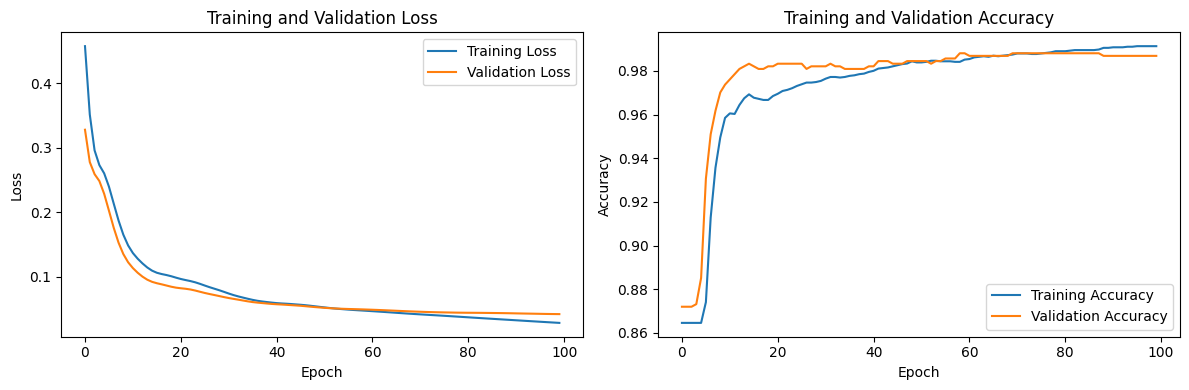

In [16]:
# lists to tensors
losses_train = torch.tensor(losses_train)
losses_val = torch.tensor(losses_val)
accuracies_train = torch.tensor(accuracies_train)
accuracies_val = torch.tensor(accuracies_val)

# training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_train.detach().numpy(), label='Training Loss')
plt.plot(losses_val.detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies_train.detach().numpy(), label='Training Accuracy')
plt.plot(accuracies_val.detach().numpy(), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Метрики на тестових даних

*Метрики*:
- Accuracy
- Precision
- Recall 
- f1

In [17]:
from sklearn.metrics import (precision_score, recall_score, f1_score)

In [19]:
test_outputs = model(X_test_embeddings)
test_outputs = (test_outputs >= 0.5).squeeze().long()


In [20]:
test_accuracy = accuracy_score(y_test, test_outputs)
test_precision = precision_score(y_test, test_outputs)
test_recall = recall_score(y_test, test_outputs)
test_f1 = f1_score(y_test, test_outputs)

In [21]:
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("f1:", test_f1)

Accuracy: 0.9844497607655502
Precision: 0.9714285714285714
Recall: 0.9107142857142857
f1: 0.9400921658986174
